# Sentinel-5 P data visualization

This is a Sentinel 5P data processing and visualisation trial notebook aimed at visualizing the northen of Italy, severly hit by <font color="coral">COVID-19</font> epidemic emergency during February 2020. In the following case study we are going to visualise `NO2` greenhouse gas levels overall decrease during the lockdown.



## Requirements

Before run this sample you have to run

```
# drb modules
pip install drb==1.0.1
pip install drb-impl-file==1.0.0
pip install drb-impl-netcdf==1.0.1
# calcul
pip install rasterio==1.2.10
pip install numpy~=1.21.2
pip install xarray==0.19.0
# diplay
pip install matplotlib==3.5.1
# Cartopy
pip install scipy==1.8.0
pip install shapely==1.8.1.post1 --no-binary shapely
pip install cartopy==0.19.0.post1
```

## Products

The products can be downloaded on https://s5phub.copernicus.eu/dhus/#/home

List of products used: 


S5P_OFFL_L2__NO2____20200201T112236_20200201T130406_11933_01_010302_20200204T163837.nc
S5P_OFFL_L2__NO2____20200213T105820_20200213T123951_12103_01_010302_20200216T160528.nc
S5P_OFFL_L2__NO2____20200222T113100_20200222T131231_12231_01_010302_20200225T163701.nc
S5P_OFFL_L2__NO2____20200304T112554_20200304T130725_12387_01_010302_20200307T163409.nc
S5P_OFFL_L2__NO2____20200311T105501_20200311T123631_12486_01_010302_20200314T154759.nc


### Using DRB

We retrieve a list of 5 Sentinel 5P product in a directory named italy
Those products are reconized as netcdf product




In [1]:
from drb.factory import DrbFactoryResolver

# directory where the files are present
uri = '/home/flf/repo/python/samples/resources/italy/'


resolver = DrbFactoryResolver()
node_dir  = resolver.create(uri)


## Filter the longitude and latitude


we select the rectangle 1.5,20,42,51 coordinates
and the variables "nitrogendioxide_tropospheric_column"


## Implementation returned by drb

The implementation returned is netCDF.Dataset
we transform it in xarray.DataSet

In [4]:
import xarray


subsets = []
# Latitude and longitude of area
xmin,xmax,ymin,ymax = (1.5,20,42,51)

for node in node_dir.children:
    
    print(node.name)
    # Exclude node that have no PRODUCT group
    if not node.has_child('root') or not node['root'].has_child('PRODUCT'):
        continue

    # Retrieve the group PRODUCT
    node_product=node['root']['PRODUCT']
    
    # Retrieve the netcdf variables nitrogendioxide_tropospheric_column
    node_var = node_product['variables']['nitrogendioxide_tropospheric_column']

    # get the DataArray of this variables
    data = node_var.get_impl(xarray.DataArray)

    # Filter on longitude / latitude
    da_sel = data.where(((data.longitude<xmax) & (data.longitude>xmin) & 
                         (data.latitude<ymax) & (data.latitude>ymin)), 
                        drop=True)

    # Calculate the number of molecules per cm2 for eache element of array
    da_conv = (da_sel.multiplication_factor_to_convert_to_molecules_percm2 * da_sel)
    
    # Add the result in subsets for display process
    subsets.append(da_conv)
    


S5P_OFFL_L2__NO2____20200201T112236_20200201T130406_11933_01_010302_20200204T163837.nc
S5P_OFFL_L2__NO2____20200213T105820_20200213T123951_12103_01_010302_20200216T160528.nc
S5P_OFFL_L2__NO2____20200222T113100_20200222T131231_12231_01_010302_20200225T163701.nc
S5P_OFFL_L2__NO2____20200304T112554_20200304T130725_12387_01_010302_20200307T163409.nc
S5P_OFFL_L2__NO2____20200311T105501_20200311T123631_12486_01_010302_20200314T154759.nc


## Display with matplotlib and cartopy

/home/flf/repo/python/samples/jupyter/venv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/flf/repo/python/samples/jupyter/venv/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/flf/repo/python/samples/jupyter/venv/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constitue

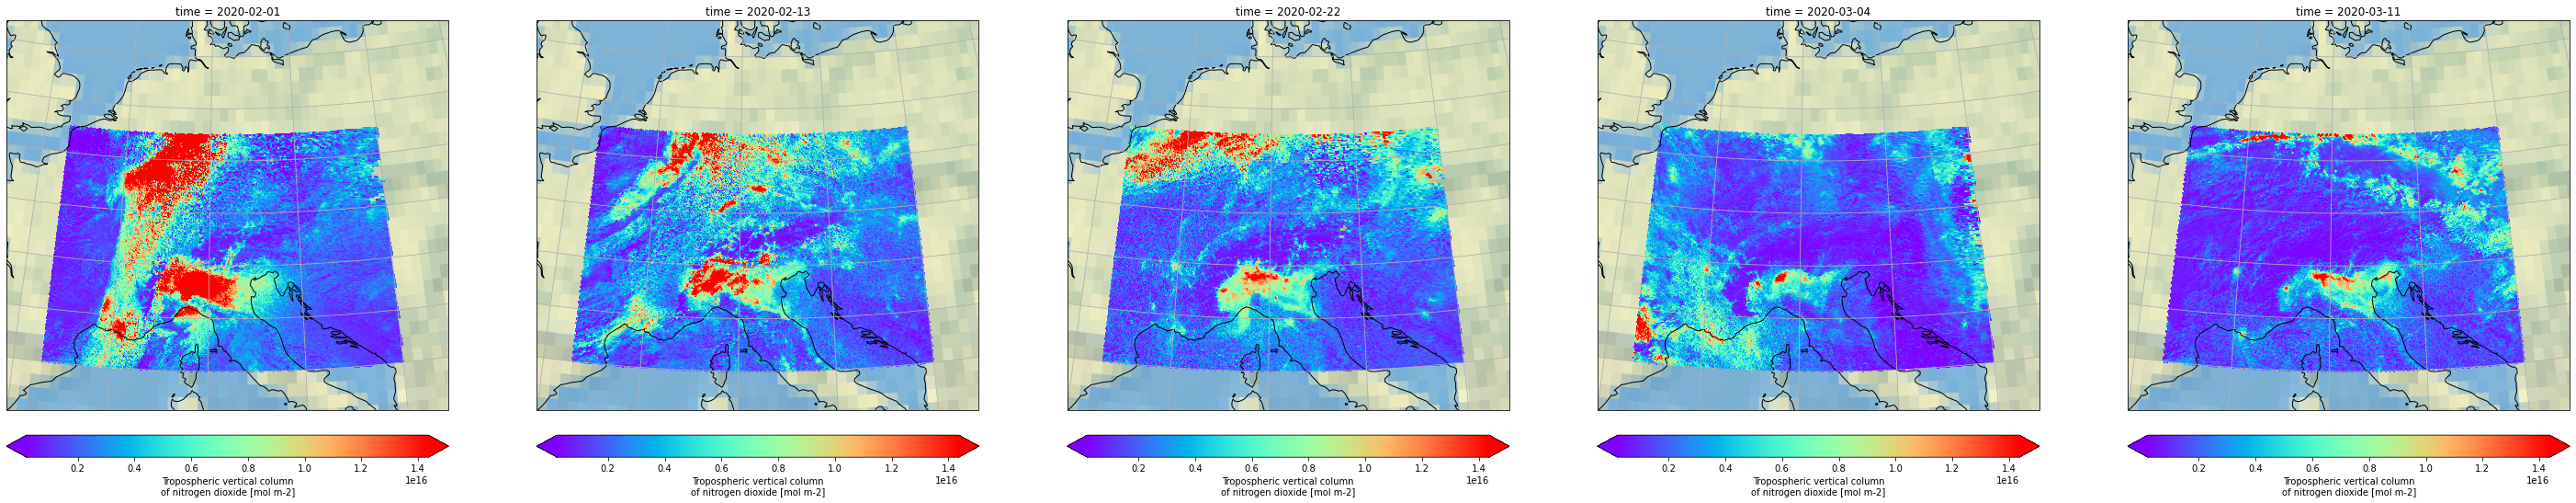

In [3]:

import os, sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

max = np.mean([d.quantile(q=0.98) for d in subsets])
min = np.mean([d.quantile(q=0.02) for d in subsets])
# print(max)
# print(min)
fig = plt.figure(figsize=(50,50))

ax = [plt.subplot(1,len(subsets),i+1,projection=ccrs.Orthographic(11,42)) for i in range(len(subsets))]
for i,im in enumerate(subsets):
    im.plot(ax=ax[i],x="longitude",y="latitude",transform=ccrs.PlateCarree(),cmap="rainbow",vmin=min,vmax=max,
                      cbar_kwargs={"orientation":"horizontal","pad":0.01})
    ax[i].coastlines("50m")
    ax[i].gridlines()
    ax[i].set_extent((0,22,40,55),crs=ccrs.PlateCarree())
    ax[i].stock_img()
    
plt.show()